In [1]:
import pandas as pd
# only load strain, country,date cols. Import them as strings
metadata = pd.read_csv("~/Desktop/openmeta.tsv.zst", sep="\t", usecols=["strain", "country", "date"], dtype=str)


In [2]:
def date_to_month(date):
    components = date.split("-")
    if len(components) >=2:
        return components[0] + "-" + components[1]
    else:
        return "?"
# coerce to string to avoid errors
metadata["date"] = metadata["date"].astype(str)
metadata["month"] = metadata["date"].apply(date_to_month)
# filter out rows with unknown month
metadata = metadata[metadata["month"] != "?"]

In [3]:
metadata.set_index("strain", inplace=True)

In [4]:
strain_to_countrymonth = {}
for strain, row in metadata.iterrows():
    strain_to_countrymonth[strain] = row["country"] + "|" + row["month"]

In [5]:
alignment_file =  "/Users/theosanderson/Desktop/openaligned.zst"
import zstandard as zstd
from Bio import SeqIO

import lzma, tqdm, random

from collections import defaultdict, Counter
total = 7e6

def identify_changing_sites():
    # loop over the alignment file, but randomly filter to just 0.1% of the sequences
    # to speed things up
    # count the characters at each site for these 
    site_counts = defaultdict(Counter)
    with zstd.open(alignment_file, "rt") as handle:
        for count, record in enumerate(tqdm.tqdm(SeqIO.parse(handle, "fasta"), total=7e6)):
            if random.random() < 0.001:
                for i in range(len(record.seq)):
                    character = record.seq[i]
                    site_counts[i][character] += 1
    
    # for each site, ignore Ns, then see if the top-most character is less than 95% of the total
    # if so, then we have a changing site
    changing_sites = []
    for site, counts in site_counts.items():
        counts['N'] = 0
        total = sum(counts.values())
        top_count = max(counts.values())
        if top_count < total * 0.95:
            changing_sites.append(site)
    return changing_sites


changing_sites = identify_changing_sites()

8820569it [09:21, 15719.14it/s]                               


In [6]:
changing_sites
# filter out <= 134 and >= 29732
changing_sites = [site for site in changing_sites if site > 134 and site < 29732]

In [7]:

def do_it():

    def get_a_defaultdict_of_counters():
        return defaultdict(Counter)

    alread_seen = set()

    by_countrymonth = defaultdict(get_a_defaultdict_of_counters)
    with zstd.open(alignment_file, "rt") as handle:
        for count, record in enumerate(tqdm.tqdm(SeqIO.parse(handle, "fasta"), total=7e6)):
            if record.id in alread_seen:
                continue
            alread_seen.add(record.id)
            if record.id in strain_to_countrymonth:
                countrymonth = strain_to_countrymonth[record.id]
                for i in changing_sites:
                    character = record.seq[i]
                    by_countrymonth[countrymonth][i][character] += 1
    return by_countrymonth
                
by_countrymonth = do_it()

8820569it [26:21, 5575.73it/s]                                 


In [8]:
keys = list(by_countrymonth.keys())
uk_keys = sorted([key for key in keys if type(key) == str and  key.startswith("Germany")])
# filter out keys containing "XXXX"
uk_keys = [key for key in uk_keys if not "XXXX" in key]

from collections import defaultdict

states = {}
top_value = {}
num_transitions = defaultdict(int)

def prop_to_state(prop):
    if prop<0.4:
        return "low"
    elif prop<0.6:
        return "medium"
    else:
        return "high"


cur_states = defaultdict(str)
cur_tops = defaultdict(str)
total_transitions = defaultdict(int)
transitions = defaultdict(list)
for key in uk_keys:
    # get the prop from the top 
    counts = by_countrymonth[key]
    # get proportions for each site in descending order
    props = {site: sorted([(char, count/sum(counts[site].values())) for char, count in counts[site].items()], key=lambda x: x[1], reverse=True) for site in counts}
    # get the top prop for each site
    top_props = {site: props[site][0][1] for site in props}
    # get the state for each site
    states = {site: prop_to_state(top_props[site]) for site in top_props}
    # get the top character for each site
    top_chars = {site: props[site][0][0] for site in props}
    
    # if either the state or the top character has changed, then we have a transition
    for site in states:
        if site < 134 or site > 29732:
            continue
    
        if states[site] != cur_states[site] or top_chars[site] != cur_tops[site]:
            if states[site]=="high":
                total_transitions[site] += 1
                transitions[site].append((key, states[site], top_chars[site]))
            cur_states[site] = states[site]
            cur_tops[site] = top_chars[site]
        if site == 22897:
            print(key, states[site], top_chars[site])
            




Germany|2020-01 high G
Germany|2020-02 high G
Germany|2020-03 high G
Germany|2020-04 high G
Germany|2020-05 high G
Germany|2020-06 high G
Germany|2020-07 high G
Germany|2020-08 high G
Germany|2020-09 high G
Germany|2020-10 high G
Germany|2020-11 high G
Germany|2020-12 high G
Germany|2021-01 high G
Germany|2021-02 high G
Germany|2021-03 high G
Germany|2021-04 high G
Germany|2021-05 high G
Germany|2021-06 high G
Germany|2021-07 high G
Germany|2021-08 high G
Germany|2021-09 high G
Germany|2021-10 high G
Germany|2021-11 high G
Germany|2021-12 high G
Germany|2022-01 high A
Germany|2022-02 medium A
Germany|2022-03 high G
Germany|2022-04 high G
Germany|2022-05 high G
Germany|2022-06 high G
Germany|2022-07 high G
Germany|2022-08 high G
Germany|2022-09 high G
Germany|2022-10 high G
Germany|2022-11 high G
Germany|2022-12 high G
Germany|2023-01 high G
Germany|2023-02 medium A
Germany|2023-03 high A
Germany|2023-04 high A
Germany|2023-05 high A
Germany|2023-06 high A
Germany|2023-07 high A
Germany

21764 8
21765 8
21766 8
21767 8
21768 8
21769 8
22916 7
23603 7
15450 6
21991 6


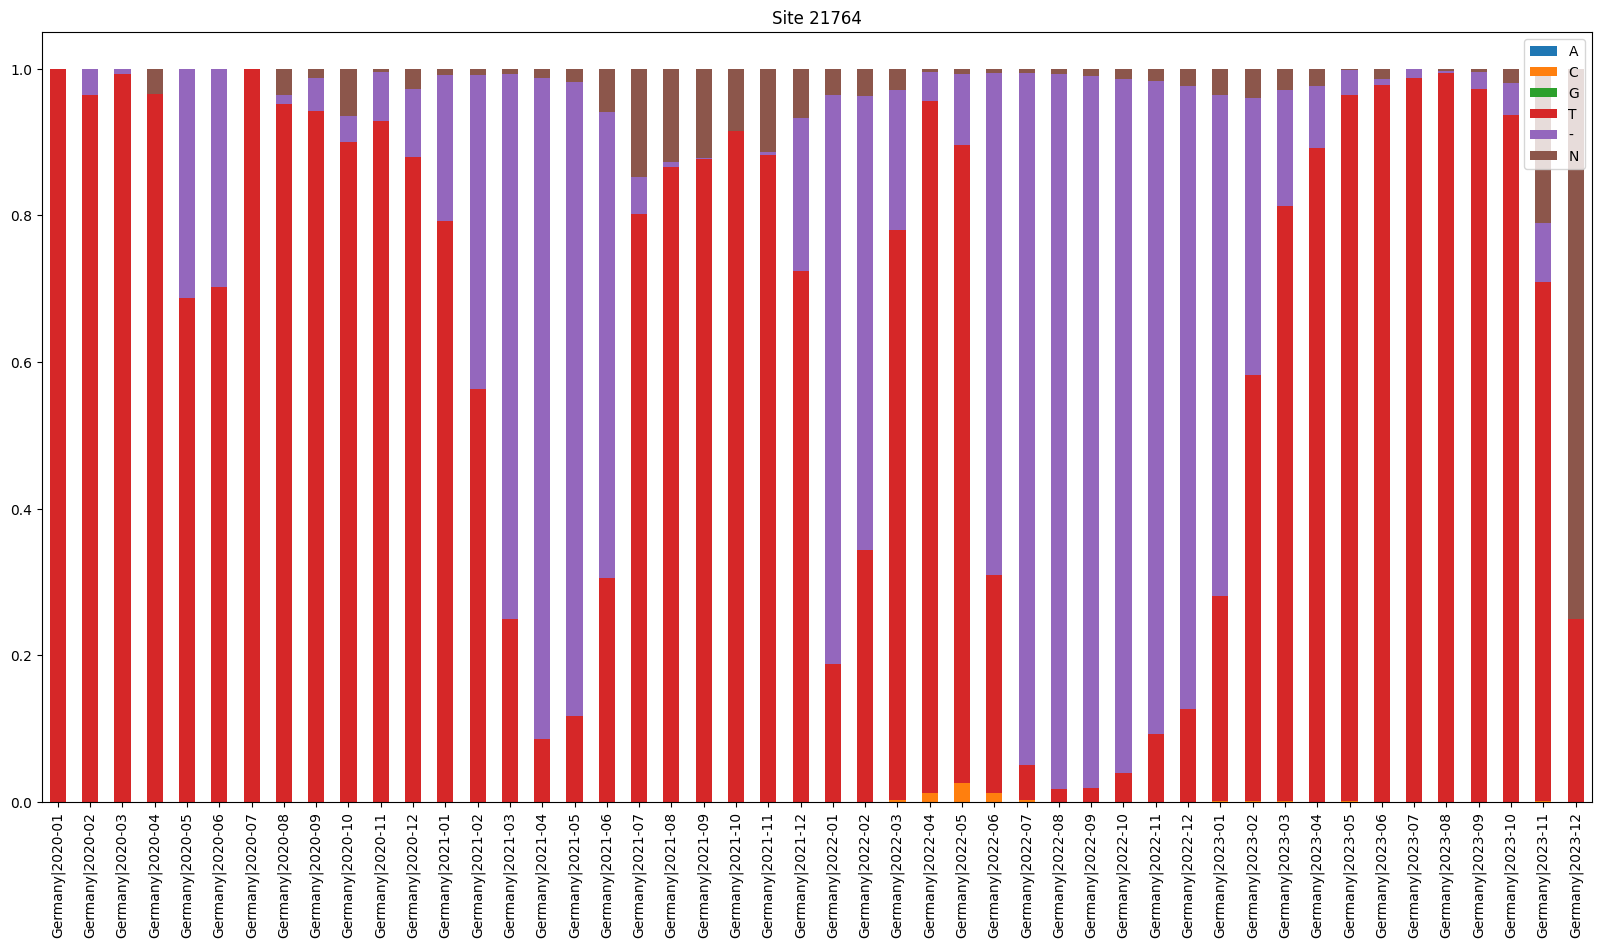

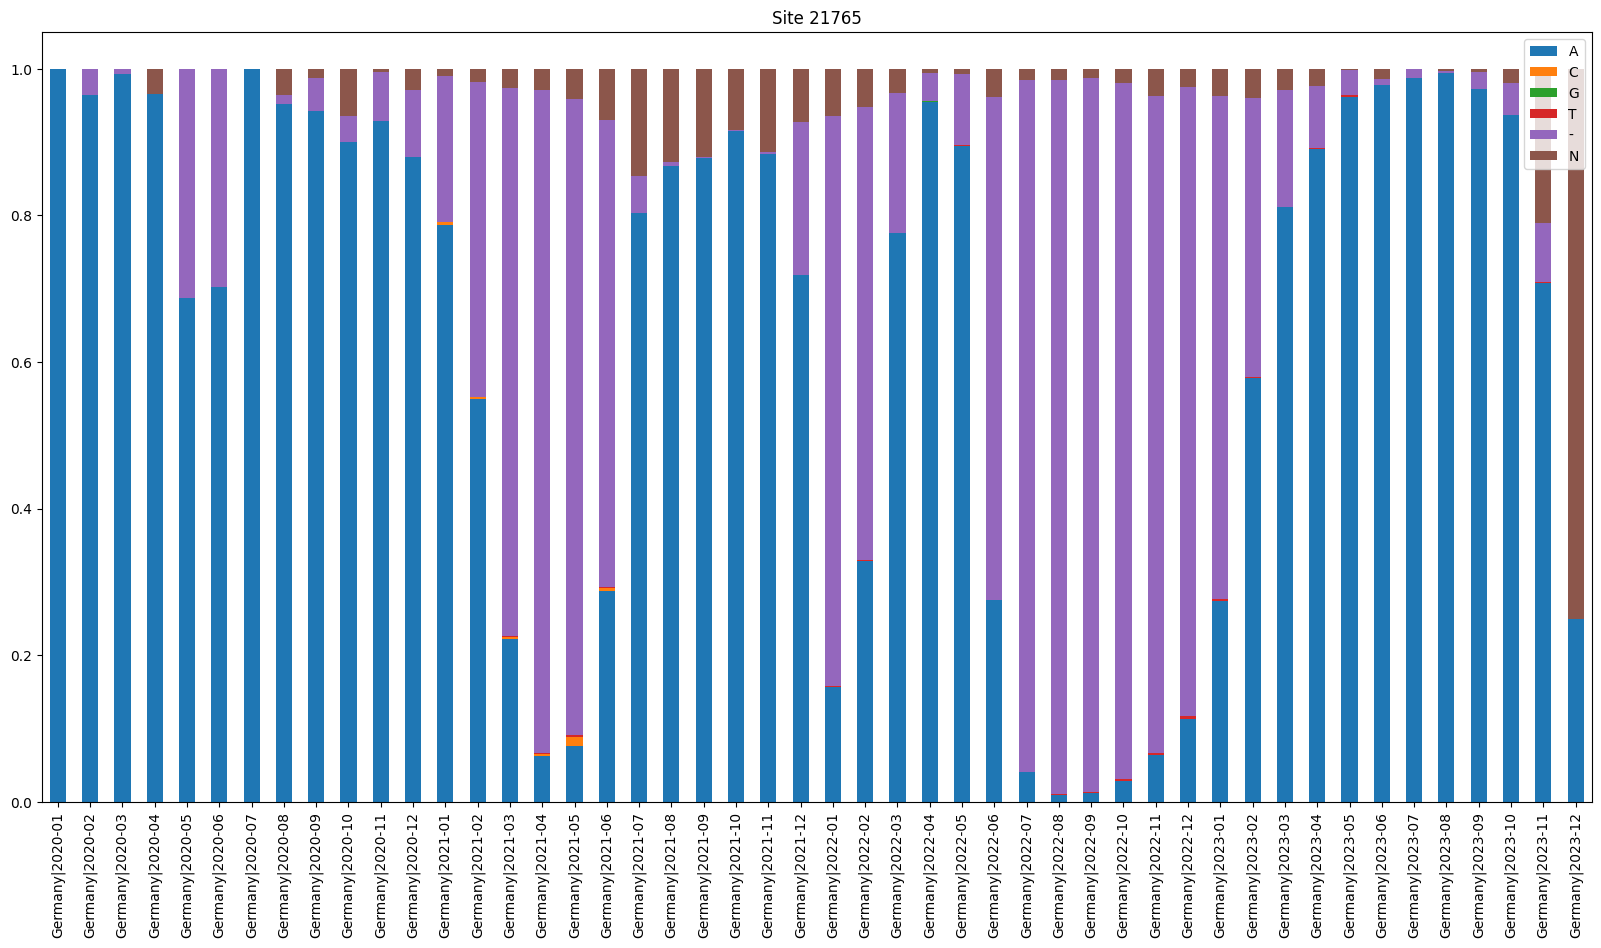

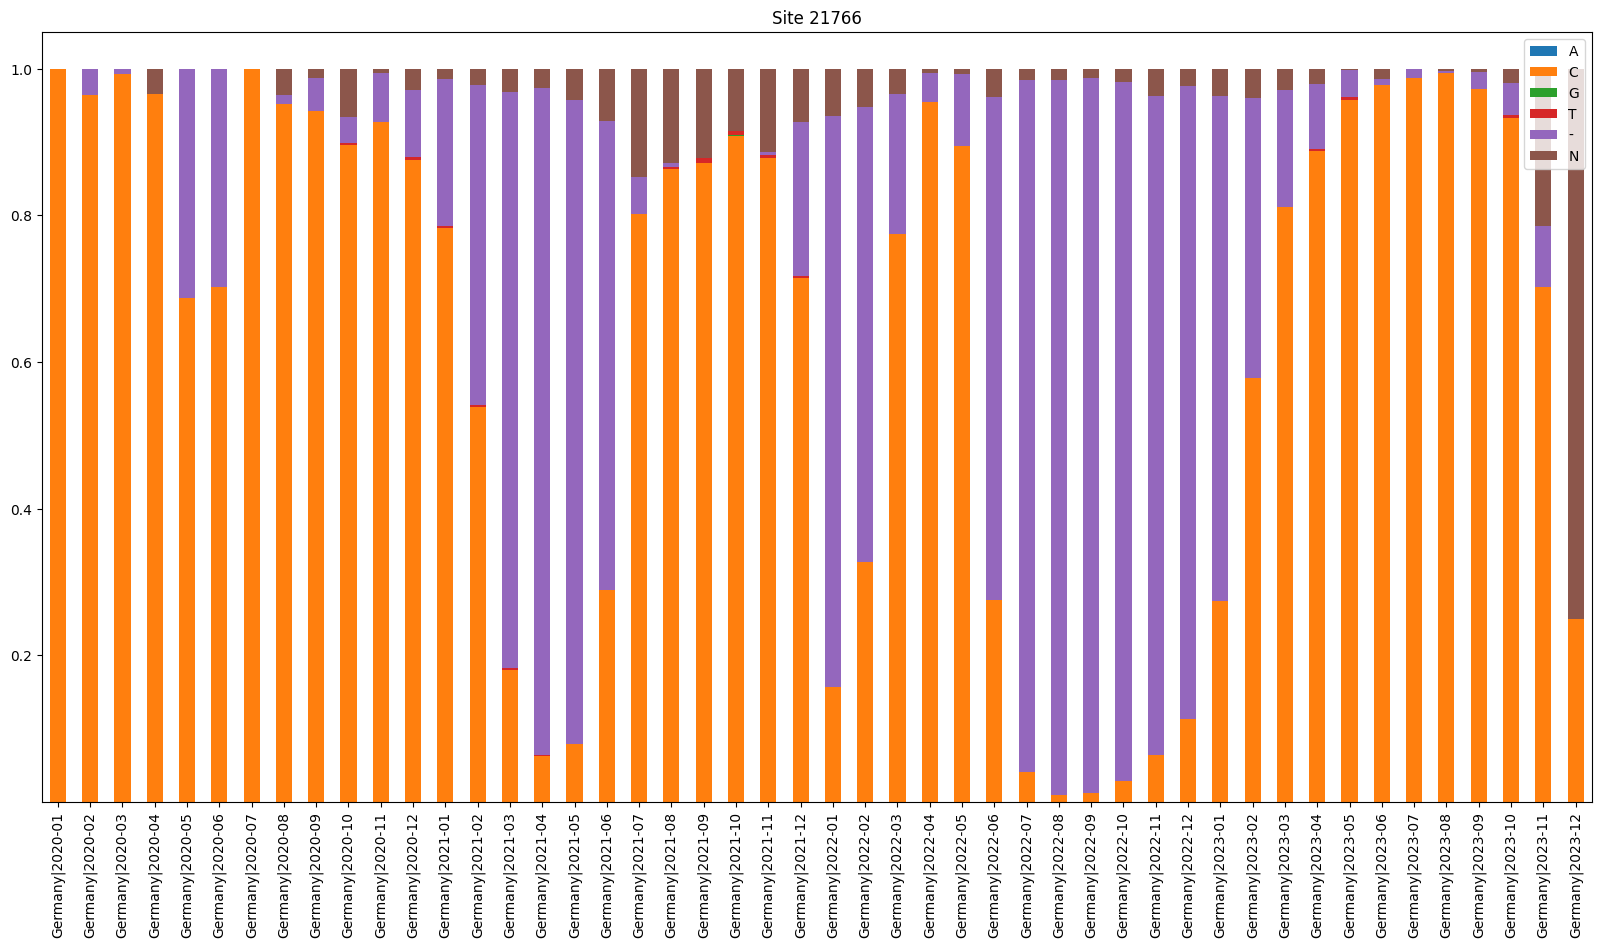

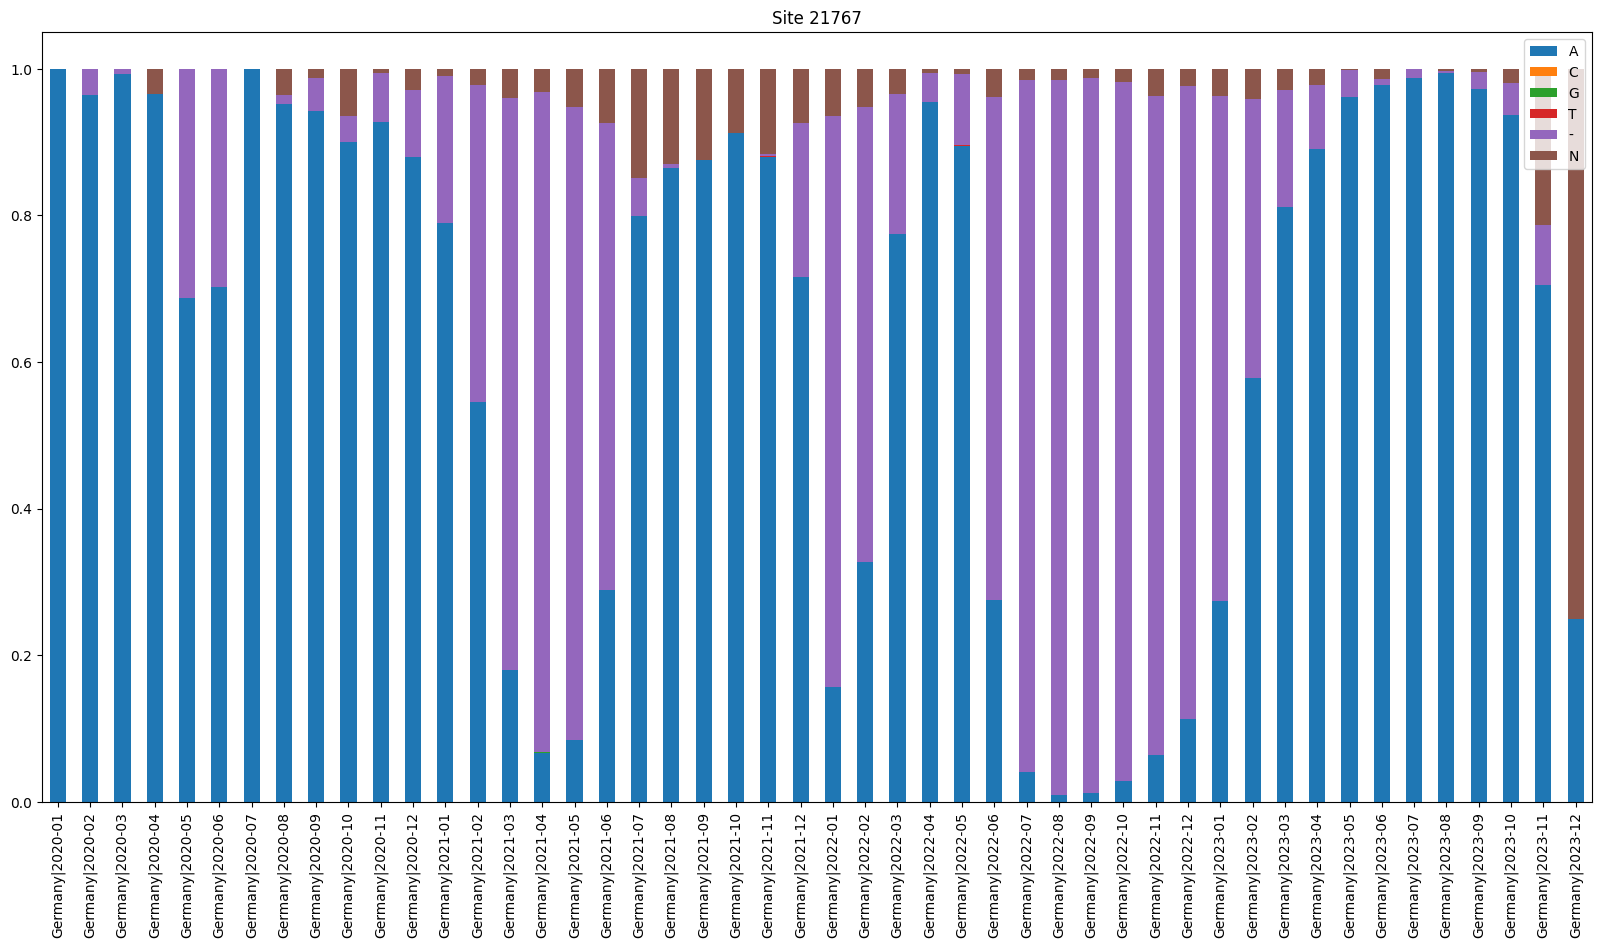

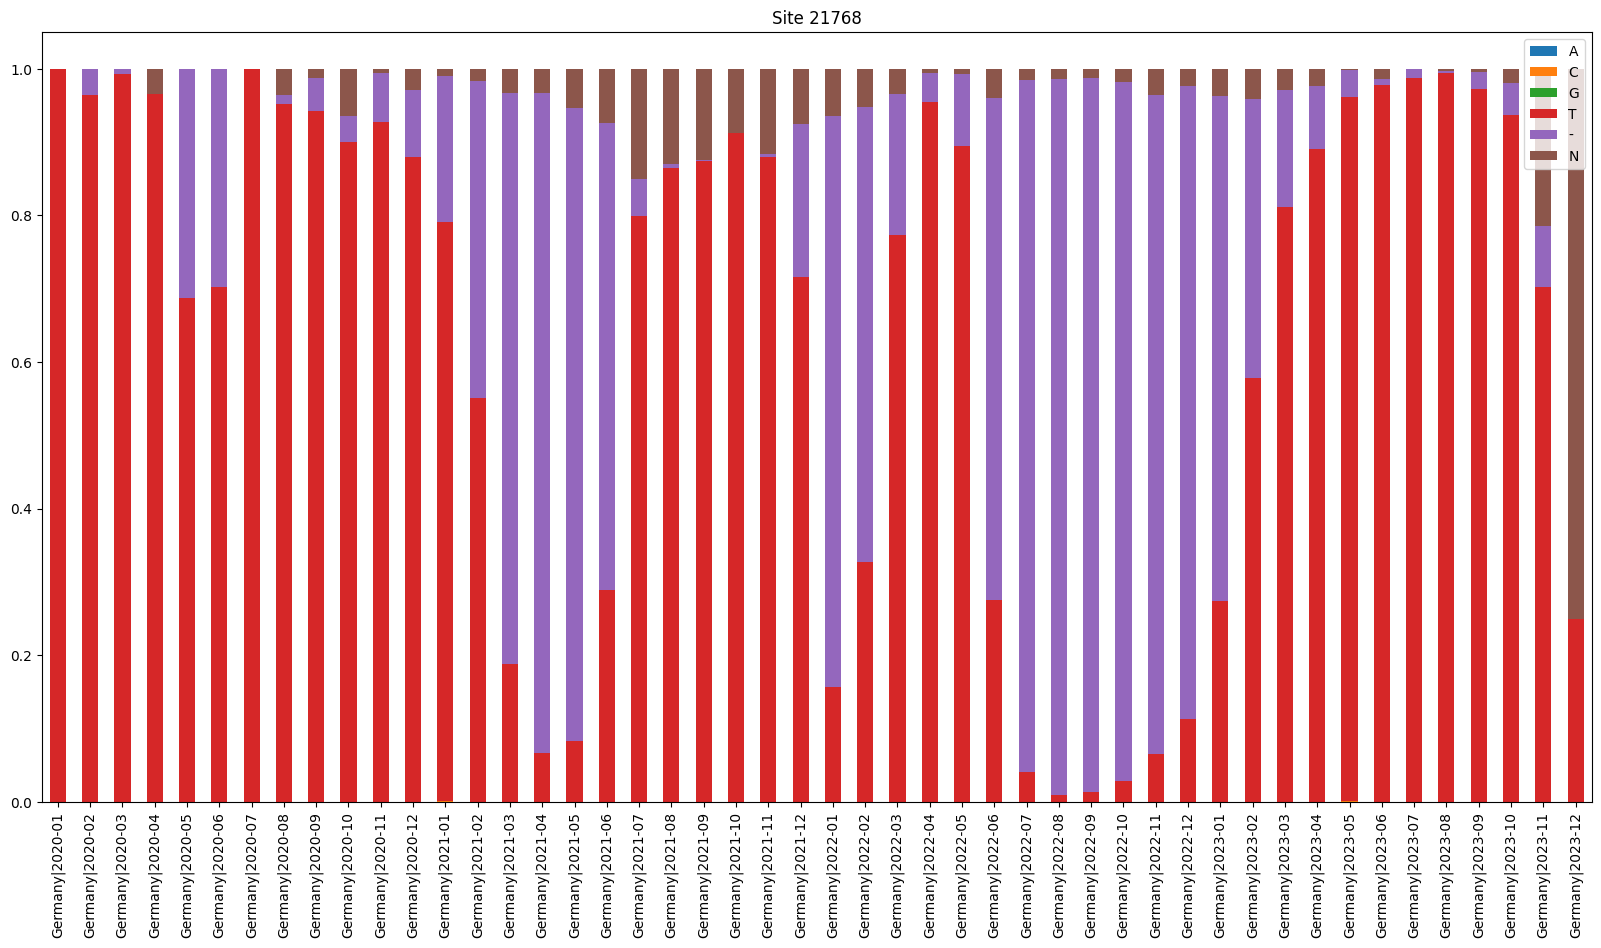

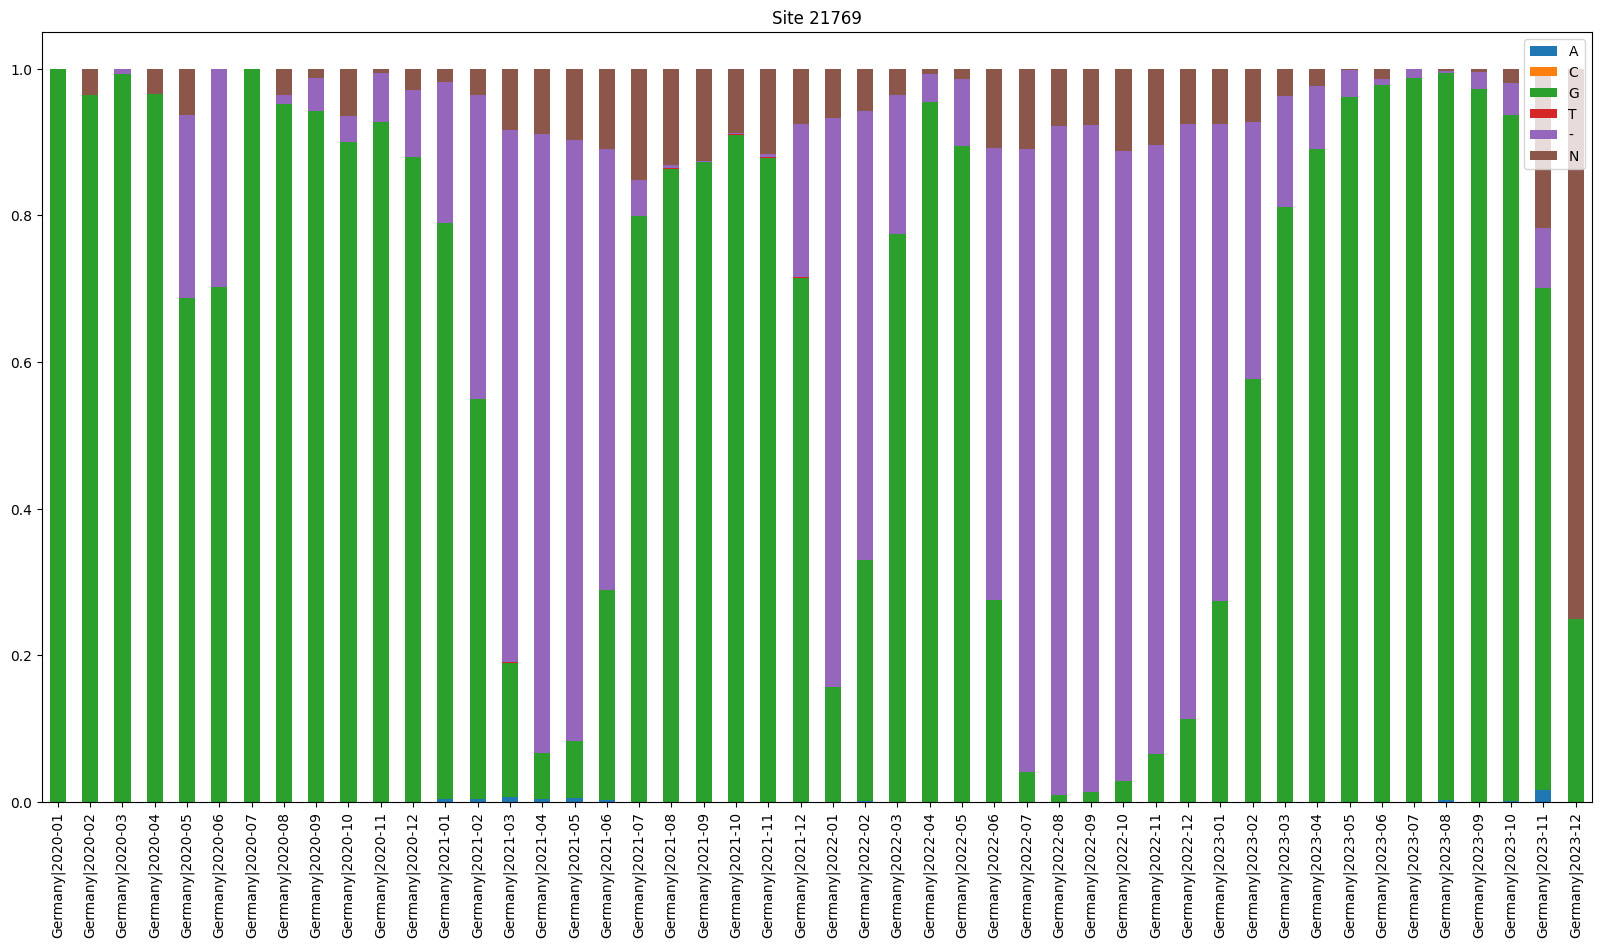

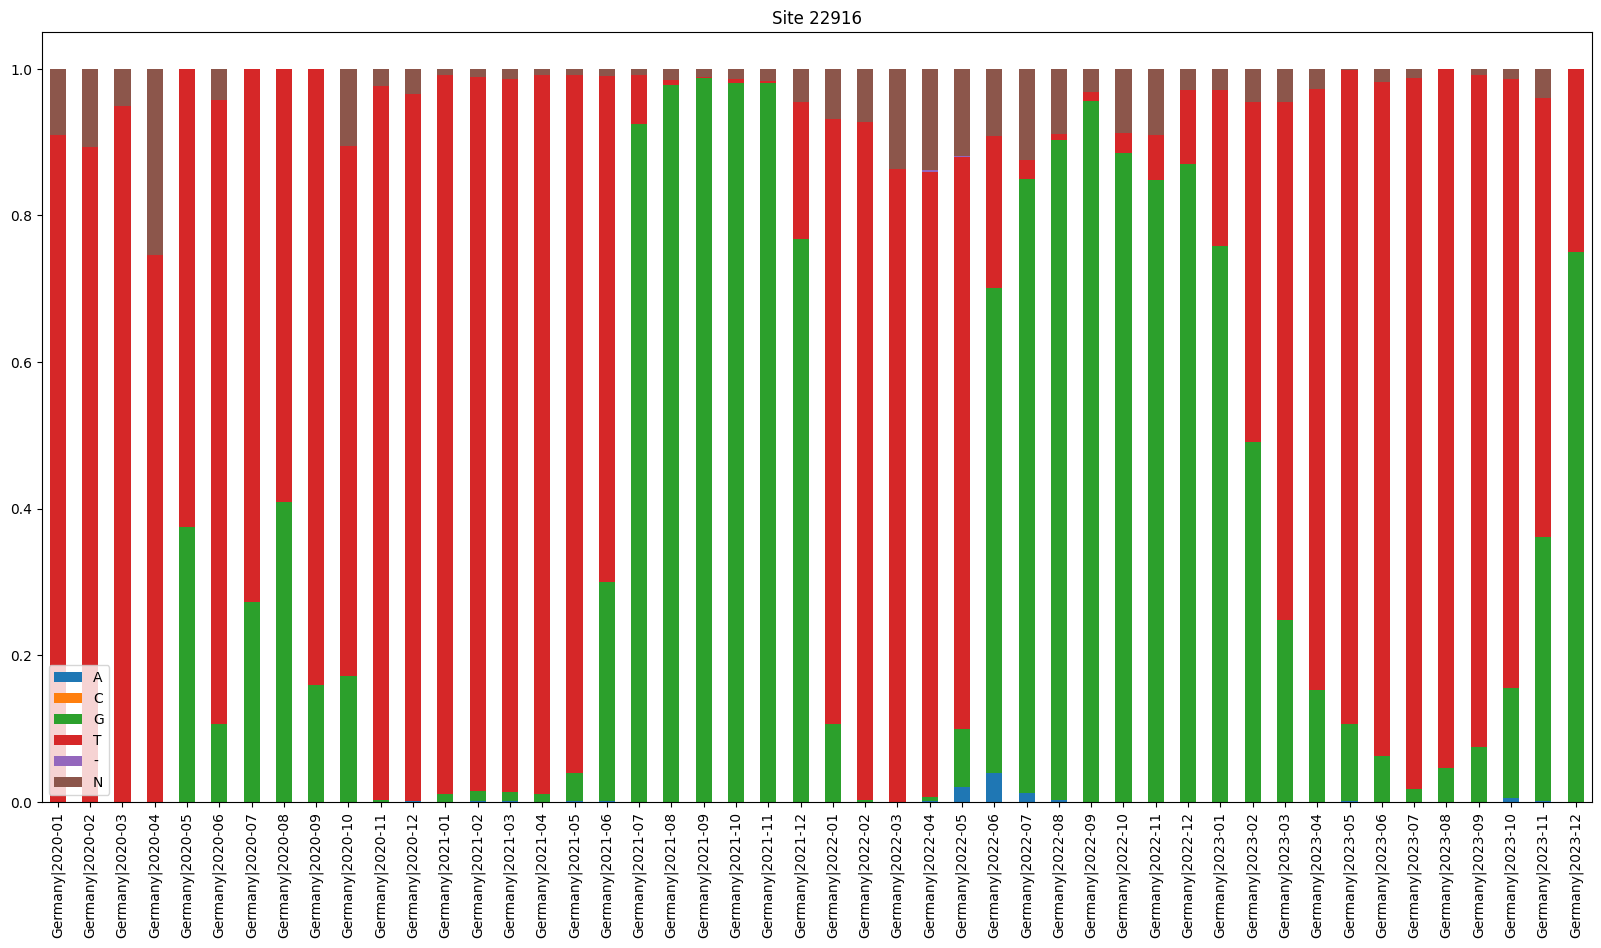

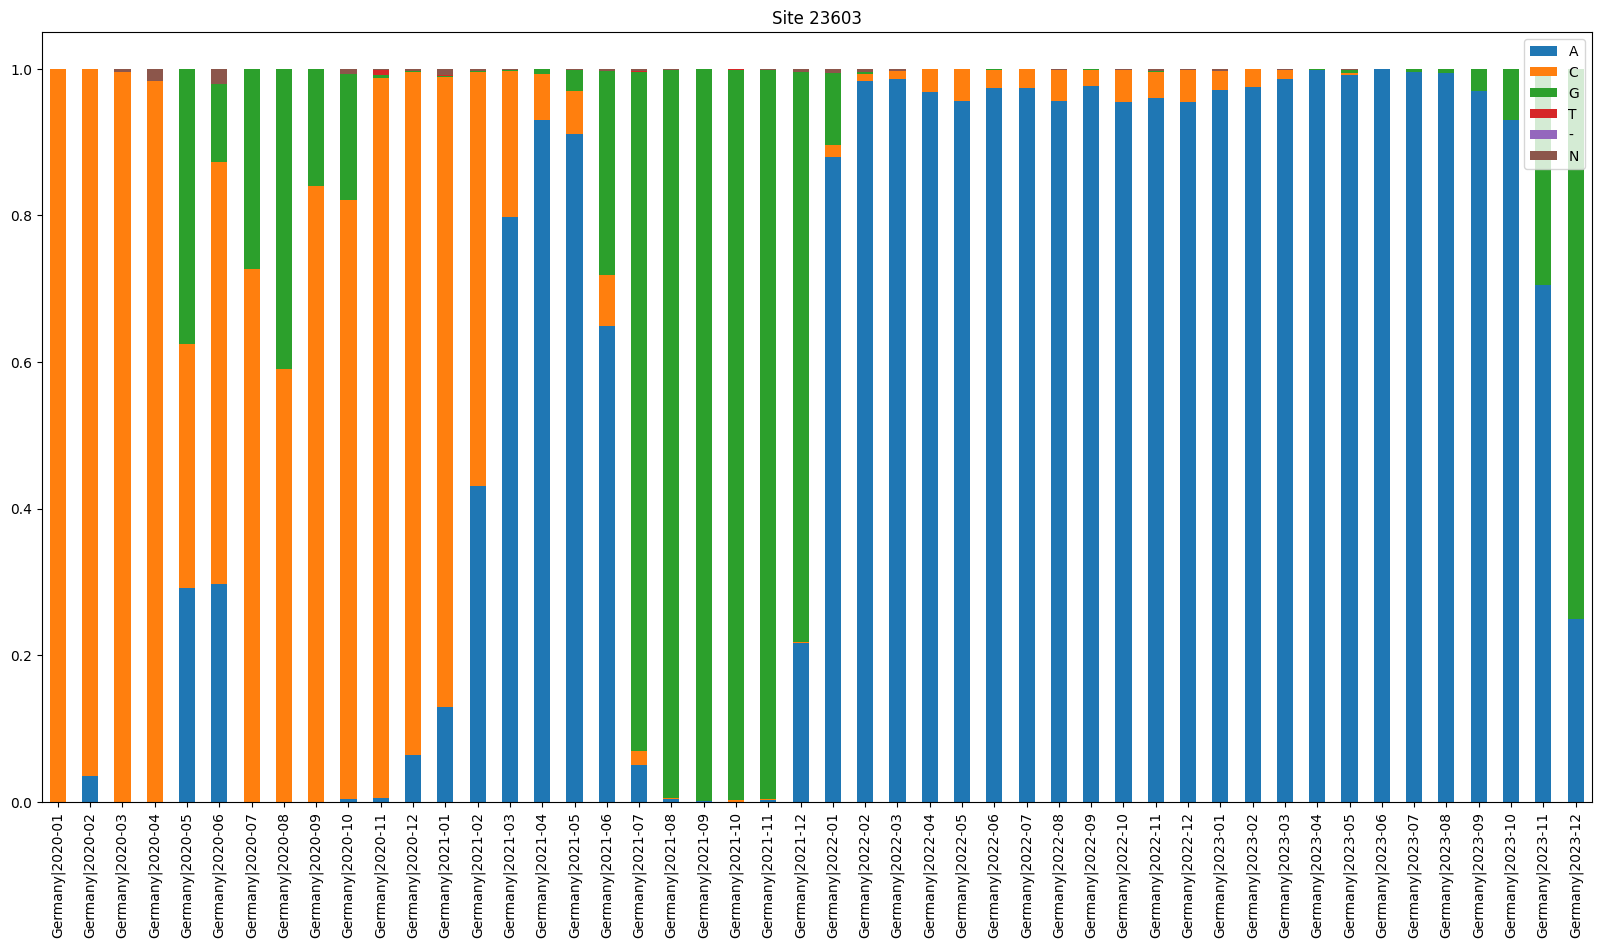

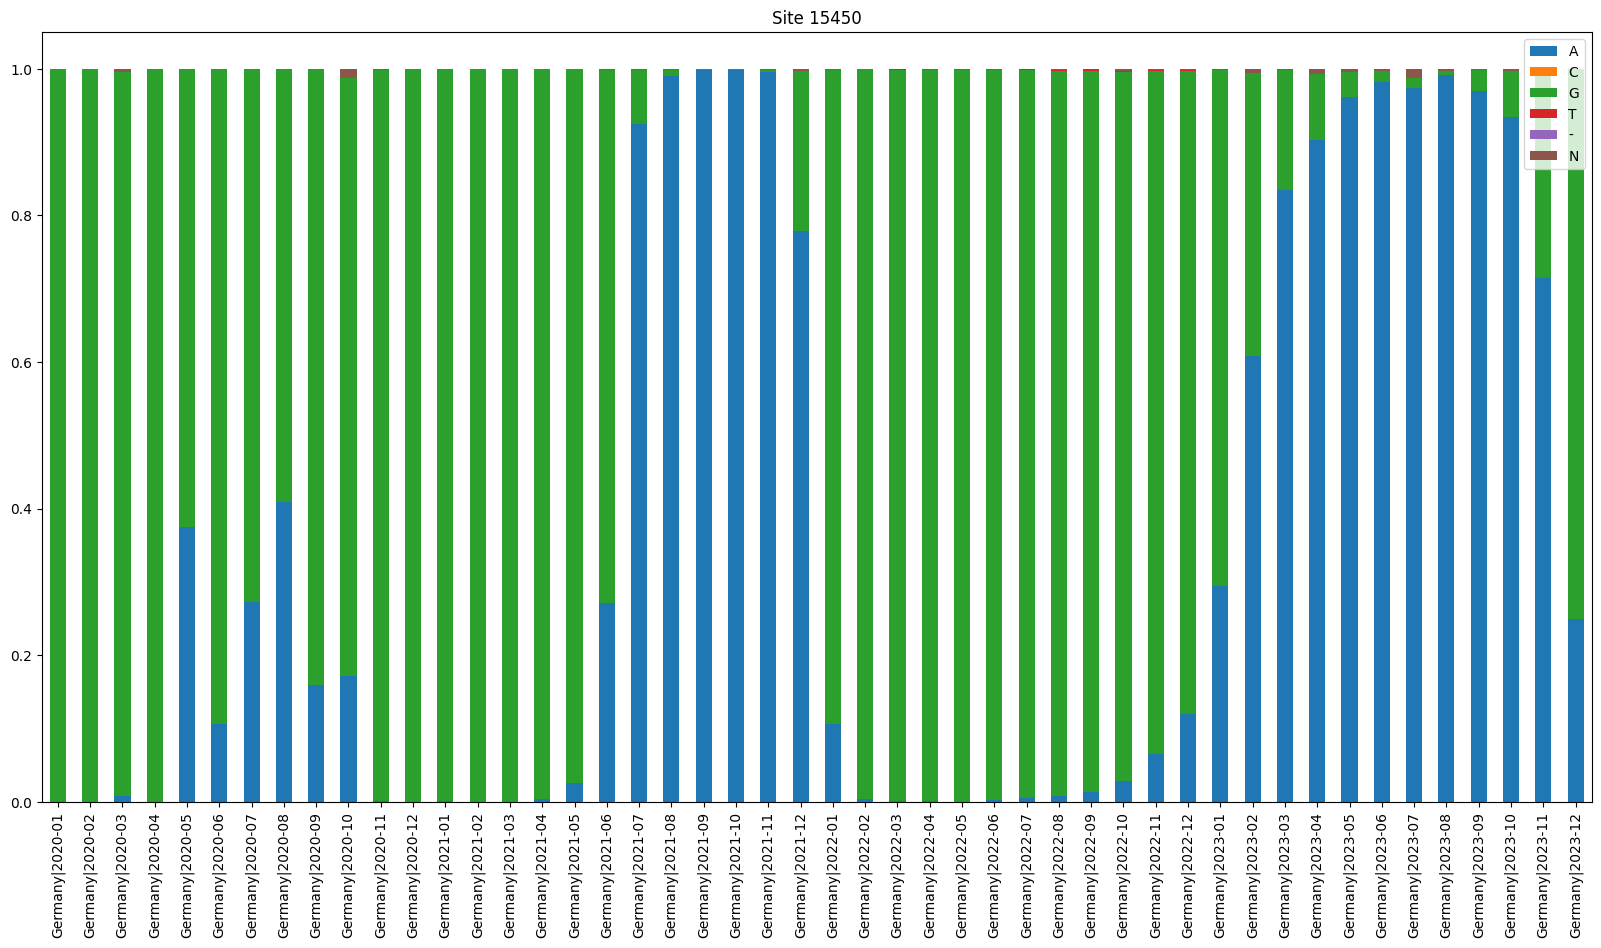

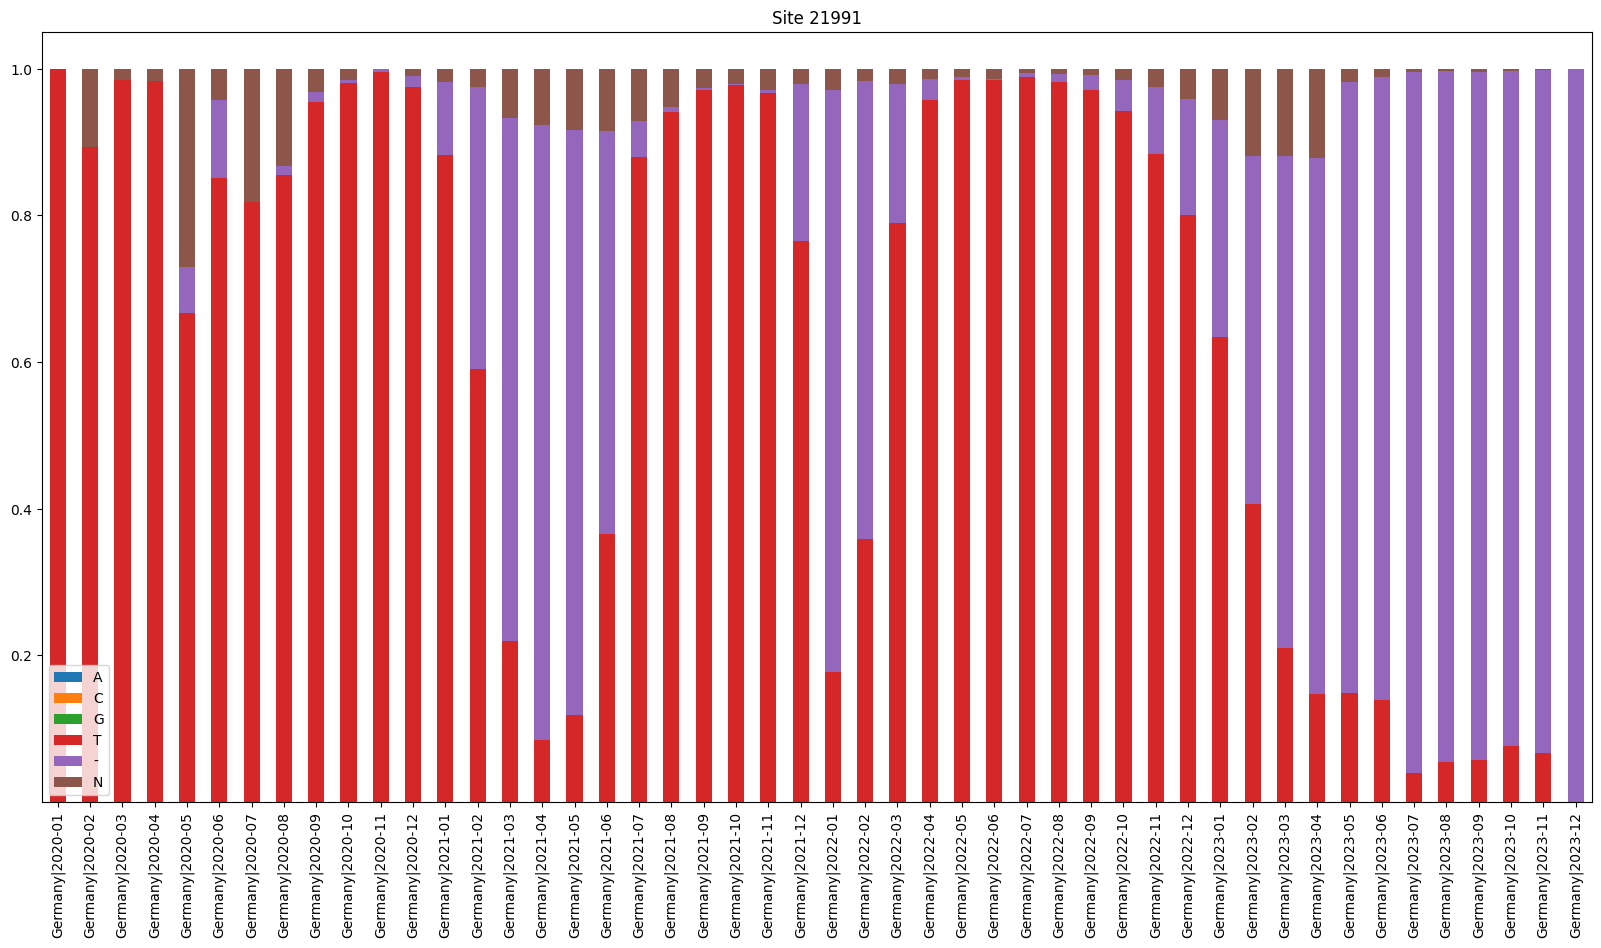

In [9]:
all_options = ['A', 'C', 'G', 'T', '-', 'N']
def plot_site(site):
    data = []
    for key in uk_keys:
        # get the prop from the top 
        counts = by_countrymonth[key][site]
       
        count_options = [counts.get(option, 0) for option in all_options]
        prop_options = [count/sum(count_options) for count in count_options]
        data.append(prop_options)

# create a dataframe with the data
    df = pd.DataFrame(data, columns=all_options, index=uk_keys)
    df.plot(kind="bar", stacked=True, figsize=(20, 10), title="Site " + str(site))

tops = sorted(total_transitions.items(), key=lambda x: x[1], reverse=True)[0:10]
for site, count in tops:
    print(site, count)
    plot_site(site)

In [ ]:
transitions[11290
            ]